# Generate IMS tile stats for input into HLS snow procedures

In [1]:
import pandas as pd
import numpy as np

In [2]:
tile_stats = pd.read_csv(r"C:\Users\mbonney\OneDrive - NRCan RNCan\Projects\High Resolution Snow Dynamics\IMS (1 km)\Outputs\tiles_IMS_ZonalSnowDynamics.csv", index_col = 0)
tile_stats = tile_stats[['smin_avg', 'smax_avg', 
                         'sstart_1819', 'sstart_1920', 'sstart_2021', 'sstart_2122', 'sstart_2223', 'sstart_2324','sstart_avg', 
                         'send_1819', 'send_1920', 'send_2021', 'send_2122', 'send_2223', 'send_2324', 'send_avg', 
                         #'slen_avg',  # Don't need actually
                         'sPer_sum', 'sFree_sum',]] # Filter to columns of interest
tile_stats

,smin_avg,smax_avg,sstart_1819,sstart_1920,sstart_2021,sstart_2122,sstart_2223,sstart_2324,sstart_avg,send_1819,send_1920,send_2021,send_2122,send_2223,send_2324,send_avg,sPer_sum,sFree_sum
0,209.857143,34.500000,20.0,14.0,-17.0,0.0,-1.0,9.0,4.166667,83.0,55.0,76.0,76.0,45.0,34.0,61.500000,0,0
1,217.142857,37.166667,19.0,14.0,-17.0,0.0,-7.0,11.0,3.333333,89.0,67.0,76.0,87.0,49.0,43.0,68.500000,0,0
2,209.714286,34.666667,20.0,14.0,17.0,5.0,-7.0,11.0,10.000000,84.0,54.0,75.0,76.0,43.0,39.0,61.833333,0,0
3,194.428571,29.833333,31.0,NaN,43.0,32.0,NaN,NaN,35.333333,75.0,NaN,63.0,70.0,NaN,NaN,69.333333,0,3
4,209.571429,36.833333,19.0,15.0,-7.0,0.0,-1.0,9.0,5.833333,76.0,54.0,76.0,76.0,44.0,34.0,60.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3386,230.714286,37.833333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,0
3387,227.142857,39.166667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,0
3388,224.714286,37.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,0
3389,229.714286,33.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,0


In [3]:
tile_stats.iloc[904]

smin_avg       226.428571
smax_avg        41.166667
sstart_1819    -86.000000
sstart_1920    -60.000000
sstart_2021    -75.000000
sstart_2122    -52.000000
sstart_2223    -60.000000
sstart_2324    -63.000000
sstart_avg     -66.000000
send_1819      156.000000
send_1920      156.000000
send_2021      149.000000
send_2122      151.000000
send_2223      150.000000
send_2324      149.000000
send_avg       151.833333
sPer_sum         0.000000
sFree_sum        0.000000
Name: 904, dtype: float64

In [4]:
# Fill in tiles without any IMS coverage with nearby values
tile_stats.loc[400] = tile_stats.loc[401] # For 400, replace with 401
tile_stats.loc[2002] = tile_stats.loc[2066] # For 2002, replace with 2066
tile_stats.loc[2139] = tile_stats.loc[2138] # For 2139, replace with 2138
tile_stats.loc[2932] = tile_stats.loc[2933] # For 2932, replace with 2933

tile_stats[tile_stats['smin_avg'].isna()]

,smin_avg,smax_avg,sstart_1819,sstart_1920,sstart_2021,sstart_2122,sstart_2223,sstart_2324,sstart_avg,send_1819,send_1920,send_2021,send_2122,send_2223,send_2324,send_avg,sPer_sum,sFree_sum


In [5]:
min_send_last = 90 # All non-perennial tiles could possibly have snow as late as March 31
max_sstart_first = 335 # All non-perennial tiles could possibly have snow as early as December 1
too_close = 15 # If sstart_first and send_last are within this many days, consider as potentially perennial

for tile in tile_stats.index:

    # Potentially perennial tiles
    if tile_stats.iloc[tile]['sPer_sum'] > 0:

        # Fill in snow_start and snow end for those missing it
        if (np.isnan(tile_stats.loc[tile, 'sstart_avg'])):
            tile_stats.loc[tile, 'sstart_avg'] = tile_stats.loc[tile, 'smin_avg'] - 364
            tile_stats.loc[tile, 'send_avg'] = tile_stats.loc[tile, 'smin_avg']

        # All potential perennial tiles should have NaN for send_last and sstart_first
        tile_stats.loc[tile, 'send_last'] = np.nan
        tile_stats.loc[tile, 'sstart_first'] = np.nan

    # Potentially snow free tiles
    elif tile_stats.iloc[tile]['sFree_sum'] > 0:

        # Calculate non-na max for send_last, use if larger than min_send_last
        send_last = tile_stats.loc[tile, ['send_1819', 'send_1920', 'send_2021', 'send_2122', 'send_2223', 'send_2324']].max()
        tile_stats.loc[tile, 'send_last'] = max(min_send_last, send_last)

        # Calculate non-na max for sstart_first, use if smaller than max_send_last
        sstart_first = tile_stats.loc[tile, ['sstart_1819', 'sstart_1920', 'sstart_2021', 
                                            'sstart_2122', 'sstart_2223', 'sstart_2324']].min() + 365
        tile_stats.loc[tile, 'sstart_first'] = min(max_sstart_first, sstart_first)

    # Regular tiles
    else:

        # send_last
        send_last = tile_stats.loc[tile, ['send_1819', 'send_1920', 'send_2021', 'send_2122', 'send_2223', 'send_2324']].max() # skipna = False
        if send_last < min_send_last:
            send_last = min_send_last
        tile_stats.loc[tile, 'send_last'] = send_last

        # sstart_first
        sstart_first = tile_stats.loc[tile, ['sstart_1819', 'sstart_1920', 'sstart_2021', 
                                             'sstart_2122', 'sstart_2223', 'sstart_2324']].min() + 365 # skipna = False
        if sstart_first > max_sstart_first: 
            sstart_first = max_sstart_first
        tile_stats.loc[tile, 'sstart_first'] = sstart_first    

        # For tiles where sstart_first and ssend_last almost overlap... consider like perennial
        if tile_stats.loc[tile, 'sstart_first'] - tile_stats.loc[tile, 'send_last'] <= too_close:
            tile_stats.loc[tile, 'send_last'] = np.nan
            tile_stats.loc[tile, 'sstart_first'] = np.nan          
        
tile_stats = tile_stats.drop(columns = ['sPer_sum', 'sFree_sum', 
                                        'send_1819', 'send_1920', 'send_2021', 'send_2122', 'send_2223', 'send_2324',
                                        'sstart_1819', 'sstart_1920', 'sstart_2021', 'sstart_2122', 'sstart_2223', 'sstart_2324'
                                        ]) # Drop unneded columns
tile_stats      

,smin_avg,smax_avg,sstart_avg,send_avg,send_last,sstart_first
0,209.857143,34.500000,4.166667,61.500000,90.0,335.0
1,217.142857,37.166667,3.333333,68.500000,90.0,335.0
2,209.714286,34.666667,10.000000,61.833333,90.0,335.0
3,194.428571,29.833333,35.333333,69.333333,90.0,335.0
4,209.571429,36.833333,5.833333,60.000000,90.0,335.0
...,...,...,...,...,...,...
3386,230.714286,37.833333,-133.285714,230.714286,NaN,NaN
3387,227.142857,39.166667,-136.857143,227.142857,NaN,NaN
3388,224.714286,37.000000,-139.285714,224.714286,NaN,NaN
3389,229.714286,33.666667,-134.285714,229.714286,NaN,NaN


In [6]:
tile_stats.iloc[904]

smin_avg        226.428571
smax_avg         41.166667
sstart_avg      -66.000000
send_avg        151.833333
send_last       156.000000
sstart_first    279.000000
Name: 904, dtype: float64

In [212]:
# # For perennial snow tiles, set as full year (no longer dropping snow free tiles)
# # drop = [] # Snow free tile indices to drop

# for tile in tile_stats.index:

#     #Fill in snow_start and snow_end for perennial snow tiles 
#     if (np.isnan(tile_stats.loc[tile, 'sstart_avg'])) & ((tile_stats.loc[tile, 'sPer_sum'] > 0)):
#         tile_stats.loc[tile, 'sstart_avg'] = tile_stats.loc[tile, 'smin_avg'] - 364
#         tile_stats.loc[tile, 'send_avg'] = tile_stats.loc[tile, 'smin_avg']   

# #     # Remove snow free tiles
# #     if (np.isnan(tile_stats.loc[tile, 'sstart_avg'])) & ((tile_stats.loc[tile, 'sFree_sum'] > 0)):
# #         drop.append(tile)

#     # Get latest snow end date (julian day) for all tiles
#     send_last = tile_stats.loc[tile, ['send_1819', 'send_1920', 'send_2021', 'send_2122', 'send_2223', 'send_2324']].max(skipna = False)
#     # If one snow end date is NA, then last should be NA

#     if send_last < 90: # Must be at least day 90 (March 31)
#         send_last = 90
    
#     tile_stats.loc[tile, 'send_last'] = send_last

#     # Get earliest snow start date (julian day) fr all tiles
#     sstart_first = tile_stats.loc[tile, ['sstart_1819', 'sstart_1920', 'sstart_2021', 
#                                          'sstart_2122', 'sstart_2223', 'sstart_2324']].min(skipna = False) + 365
#     # If one snow start date is NA, then first should be NA

#     if sstart_first > 335: # Can't be later than day 335 (December 1)
#         sstart_first = 335
    
#     tile_stats.loc[tile, 'sstart_first'] = sstart_first

#     # For potentially snow free tiles, provide send_last and sstart first
#     if (np.isnan(tile_stats.loc[tile, 'send_last'])) & ((tile_stats.loc[tile, 'sFree_sum'] > 0)):
#         tile_stats.loc[tile, 'send_last'] = 90
#         tile_stats.loc[tile, 'sstart_first'] = 335

#     # # For tiles where sstart_first and ssend_last almost overlap... within two weeks (almost Perennial)
#     if tile_stats.loc[tile, 'sstart_first'] - tile_stats.loc[tile, 'send_last'] <= 15: # 30 originally
#         tile_stats.loc[tile, 'send_last'] = np.nan
#         tile_stats.loc[tile, 'sstart_first'] = np.nan        
        
# # tile_stats = tile_stats.drop(drop)
# tile_stats = tile_stats.drop(columns = ['sPer_sum', 'sFree_sum', 
#                                         'send_1819', 'send_1920', 'send_2021', 'send_2122', 'send_2223', 'send_2324',
#                                         'sstart_1819', 'sstart_1920', 'sstart_2021', 'sstart_2122', 'sstart_2223', 'sstart_2324'
#                                         ]) # Drop unneded columns
# tile_stats

In [213]:
#tile_stats.iloc[2948]

In [214]:
#tile_stats.loc[904, ['send_1819', 'send_1920', 'send_2021', 'send_2122', 'send_2223', 'send_2324']]#.min()

# send_first/sstart_last do not make sense for tile-based results because they are based on 1% found (sstart) and <1% remain (ssend)

In [215]:
#tile_stats[tile_stats['sstart_first'] - tile_stats['send_last'] <= 35]

## smin_avg
- Average minimum snow date (2018 - 2024) - Julian day
- Used to define winter year

182.57142857142856
276.42857142857144
0


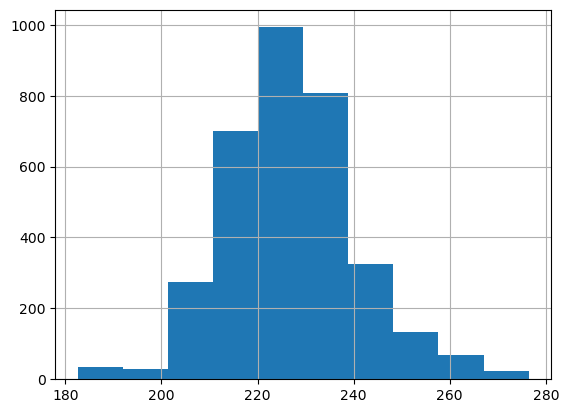

In [216]:
tile_stats['smin_avg'].hist()
print(tile_stats['smin_avg'].min())
print(tile_stats['smin_avg'].max())
print(len(tile_stats[tile_stats['smin_avg'].isna()]))

## smax_avg
- Average maximum snow date (2018 - 2024) - Julian day
- Used to define snow peak when looking at observation frequency

0.1666666666666666
90.16666666666669
0


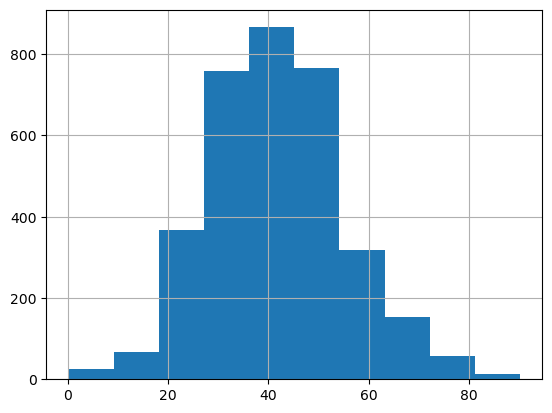

In [217]:
tile_stats['smax_avg'].hist()
print(tile_stats['smax_avg'].min())
print(tile_stats['smax_avg'].max())
print(len(tile_stats[tile_stats['smax_avg'].isna()]))

## sstart_avg
- Average snow start date (2018 - 2024) - Days since Dec 31
- Used to define snow fall and snow season when looking at observation frequency

-181.0
62.333333333333336
38


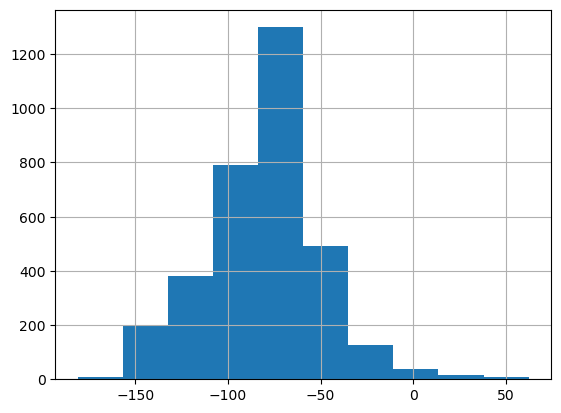

In [218]:
tile_stats['sstart_avg'].hist()
print(tile_stats['sstart_avg'].min())
print(tile_stats['sstart_avg'].max())
print(len(tile_stats[tile_stats['sstart_avg'].isna()])) # Snow free tiles

## send_avg
- Average snow end date (2018 - 2024) - Days since Dec 31
- Used to define snow melt and snow season when looking at observation frequency

21.0
271.85714285714283
38


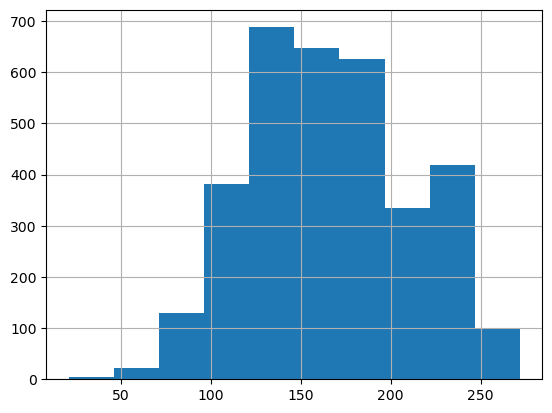

In [219]:
tile_stats['send_avg'].hist()
print(tile_stats['send_avg'].min())
print(tile_stats['send_avg'].max())
print(len(tile_stats[tile_stats['send_avg'].isna()])) # Snow free tiles

## send_avg and sstart_avg difference
- Good that always positive

16.75
364.0
38


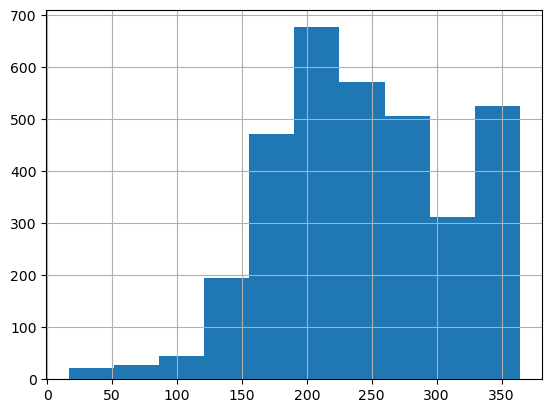

In [220]:
(tile_stats['send_avg'] - tile_stats['sstart_avg']).hist()
print((tile_stats['send_avg'] - tile_stats['sstart_avg']).min())
print((tile_stats['send_avg'] - tile_stats['sstart_avg']).max())
print((tile_stats['send_avg'] - tile_stats['sstart_avg']).isna().sum()) # Snow free tiles

## send_last
- Latest record snow end date (2018 - 2024) - Julian day
- Earliest = 90 (March 31) - assuming always possible to have snow on ground anywhere in Canada before this date
- Used to remove "implausable snow" during cleaning procedure

90.0
253.0
683


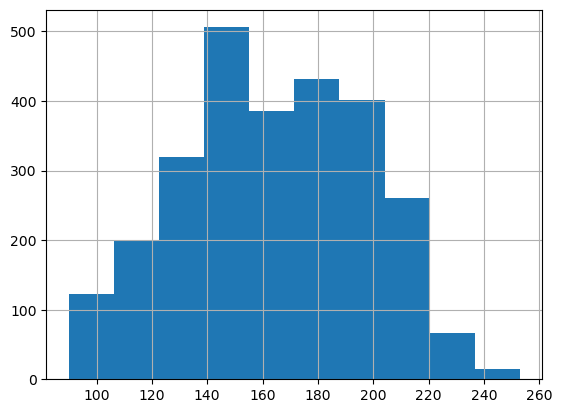

In [221]:
tile_stats['send_last'].hist()
print(tile_stats['send_last'].min())
print(tile_stats['send_last'].max())
print(len(tile_stats[tile_stats['send_last'].isna()])) # Perennial snow tiles

## sstart_first
- Earliest recorded snow start date (2018 - 2024) - Julian day
- Latest = 330 (Nov 26) - assuming always possible to have snow on ground anyone in Canada after this date
- Used to remove "implausable snow" during cleaning procedure

223.0
335.0
683


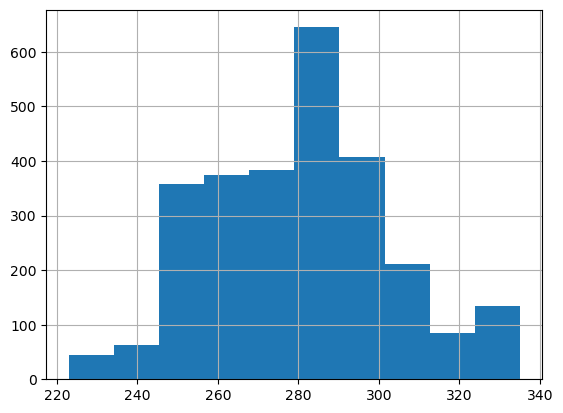

In [222]:
tile_stats['sstart_first'].hist()
print(tile_stats['sstart_first'].min())
print(tile_stats['sstart_first'].max())
print(len(tile_stats[tile_stats['sstart_first'].isna()])) # Perennial snow tiles

## sstart_first and send_last difference
- Should be always positive (<= 30 = NaN)
- NaN = no time is implausable snow

16.0
245.0
683


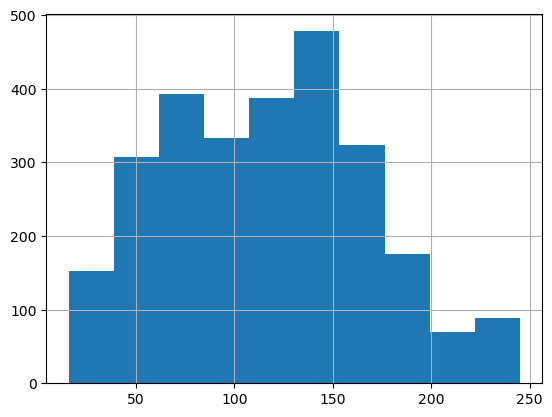

In [223]:
(tile_stats['sstart_first'] - tile_stats['send_last']).hist()
print((tile_stats['sstart_first'] - tile_stats['send_last']).min())
print((tile_stats['sstart_first'] - tile_stats['send_last']).max())
print((tile_stats['sstart_first'] - tile_stats['send_last']).isna().sum()) # Perennial snow tiles

In [224]:
tile_stats.astype('float32').to_csv('tiles_IMS_SnowDynamics4HLS.csv')

In [225]:
# [int(tile_stats.loc[900, 'send_last']), int(tile_stats.loc[900, 'sstart_first'])]

In [7]:
tile = 904 # 900 # 3 # 3390

if np.isnan(tile_stats.loc[tile, 'send_last']) == True:
    implausable_snow = []
else: # Week buffer from latest recorded end date and earliest recorded start date
    implausable_snow = [int(tile_stats.loc[tile, 'send_last']) + 7, int(tile_stats.loc[tile, 'sstart_first']) - 7]
implausable_snow

[163, 272]

In [172]:
len(implausable_snow)

0

# Testing

In [ ]:
#len(tile_stats) # 3391
#len(tile_stats[tile_stats['sPer_sum'] > 0]) 614
#len(tile_stats[tile_stats['sFree_sum'] > 0]) # 66
#len(tile_stats[(tile_stats['sFree_sum'] == 0) & (tile_stats['sPer_sum'] == 0)]) # 2711

In [ ]:
# send_last = tile_stats.loc[1506, ['send_1819', 'send_1920', 'send_2021', 'send_2122', 'send_2223', 'send_2324']].max(skipna = False)
# if send_last < 90: # Must be at least day 90 (March 31)
#     send_last = 90
# send_last

In [ ]:
# sstart_first = tile_stats.loc[1506, ['sstart_1819', 'sstart_1920', 'sstart_2021', 
#                                      'sstart_2122', 'sstart_2223', 'sstart_2324']].min(skipna = False) + 365
# if sstart_first > 335: # Can't be later than day 335 (December 1)
#     sstart_first = 335
# sstart_first

In [ ]:
# tile_stats.loc[tile, 'send_last'] = 90
# tile_stats.loc[tile, 'sstart_first'] = 335

In [ ]:
#tile_stats[np.isnan(tile_stats['sstart_avg']) & ((tile_stats['sPer_sum'] == 0))]

In [ ]:
#tile_stats[['send_1819', 'send_1920', 'send_2021', 'send_2122', 'send_2223', 'send_2324']].mean(axis = 1, skipna = False)

In [ ]:
#~np.isnan(tile_stats[['send_1819', 'send_1920', 'send_2021', 'send_2122', 'send_2223', 'send_2324']].mean(axis = 1, skipna = False))

In [ ]:
#tile_stats[(tile_stats['sPer_sum'] > 0) & np.isnan(tile_stats[['send_1819', 'send_1920', 'send_2021', 'send_2122', 'send_2223', 'send_2324']].mean(axis = 1, skipna = False))]

In [ ]:
#max(tile_stats.loc[1506, 'send_1819'], tile_stats.loc[1506, 'send_1920'])

In [ ]:
# min_send_last = 90
# send_last = tile_stats.loc[1506, ['send_1819', 'send_1920', 'send_2021', 'send_2122', 'send_2223', 'send_2324']].max()
# max(min_send_last, send_last)

In [ ]:
# max_sstart_first = 335
# sstart_first = tile_stats.loc[1506, ['sstart_1819', 'sstart_1920', 'sstart_2021', 
#                                      'sstart_2122', 'sstart_2223', 'sstart_2324']].min() + 365
# tile_stats.loc[1506, 'sstart_first'] = min(max_sstart_first, sstart_first)
# min(max_sstart_first, sstart_first)